### Given the scarcity of data in this task, we will use k-Fold cross-validation for training with k set to a large value to make a good use of the available data of a significantly small size.

#### Following are the hyperparameters that can be tuned for a neural network

1. learning rate
2. no of hidden units
3. no of epochs to train
4. dropout probability
5. loss function (NOT TUNED HERE)
6. mini batch size
7. weights initialization (NOT TUNED HERE)
8. l1/ l2 regularizers
9. activation function to use at the nodes (NOT TUNED HERE)
10. no of layers (NOT TUNED HERE)
11. learning rate decay (NOT TUNED HERE)
12. optimizer (NOT TUNED HERE)
13. momentum (only if sgd or rmsprop optimizer used, not with adam, adagrad)
14. momentum_dampening (only if sgd or rmsprop optimizer used, not with adam, adagrad) (NOT TUNED HERE)


There are several methods to tune hyperparameters of a neural network. Two of them are grid search and randomized search that select points in the parameter space and evaluate these points (each point is essestially a unique configuration of hyperparameters in the hyperparameter space) and return the best hyperparameter combination based on the performace on the validation data.

#### How is grid search/ randomized search done with k-fold cross validation?
1. Select n points in the hyperparameter space. For each point, do:
    a. Each point corresponds to a hyperparameter configuration in the hyperparameter space.
    b. Train and evaluate this model k times as follows.
        i. Randomly divide the training data into k partitions. Call them partition 1, partition 2,.........., partition k.
        ii. Repeat for each partition j starting from j = 1 to j = k
            . Train the model with this hyperparameter configuration on the partitions except partition j and test on                     partition j.
            . Store the performance of the model.
        iii. Calculate the average performance of the model with this hyperparameter configuration over the k folds.
2. Declare the model that was trained using the hyperparameters corresponding to the point that achieved the best              validation result as the best model and declare this choice of hyperparameters as the best hyperparameters.
3. Predict the labels of the testing data using this model.

### Import Libraries

In [287]:
import time
import copy
import sys
import os
import random
import csv
from math import sqrt


import numpy as np

import pandas as pd

import seaborn as sns


import sklearn
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skorch.callbacks import Callback
from Custom_Skorch_Callback import Epoch_TestData_Loss

from joblib import dump, load

### Custom Callback Class for skorch

In [288]:
class Epoch_TestData_Loss(Callback):
    
    def __init__(self, testing_X, testing_Y, counter):
        self.testing_X = torch.FloatTensor(testing_X)
        self.testing_Y = torch.FloatTensor(testing_Y)
        self.counter = counter
        
    def on_epoch_begin(self, net, **kwargs):
        """Called at the beginning of each epoch."""
        
        
        net.module_.train()  # Since we switch to eval() mode at the end of each epoch, need to revert back
        
    def on_epoch_end(self, net, **kwargs):
        """Called at the end of each epoch."""        
        
        
        
        # switch to eval mode for torch nn
        net.module_.eval()
        
        test_predictions = net.module_(self.testing_X)
        criterion = torch.nn.MSELoss()
        #print(test_predictions.shape, self.testing_Y.shape)
        
        assert len(test_predictions) == len(self.testing_Y)
        
        loss = criterion(test_predictions, self.testing_Y)
        
        # Store the test loss for the current epoch
        
        # skorch neural net has a history
        # history : a list of dicts for each epoch, that, again, contains a list of dicts for each batch
        
        history = net.history # skorch neural net has a history
                              # history : a list of dicts for each epoch, that, again, 
                              # contains a list of dicts for each batch
        
        # add an entry to the current epoch
        # (here we want to record the test data performance at the end of each epoch)
        history.record('test_loss', loss)
        
    def on_train_end(self, net, ** kwargs):
        '''Called once at the end of the training process.'''
        
        # Plot loss graph for the model at the end of the last epoch of training
        
        train_loss = net.history[:,'train_loss']
        test_loss = net.history[:,'test_loss']
        epochs = [i for i in range(len(train_loss))]
        
        
        import matplotlib.pyplot as plt0
        
        plt0.plot(epochs,train_loss,'g-')
        plt0.plot(epochs,test_loss,'r-')
        plt0.title('Loss Curves')
        plt0.xlabel('Epochs')
        plt0.ylabel('Mean Squared Error')
        plt0.legend(['Train','Test'])
        
        # Save the figure and show
        plt0.tight_layout()
        plt0.savefig('../plots/train_and_test_loss_' + str(self.counter) +'.png')
        plt0.show()
        
       

In [289]:
print("The python version used is {}".format(sys.version))
print("The torch version used is {}".format(torch.__version__))
print("The sklearn version used is {}".format(sklearn.__version__))

The python version used is 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
The torch version used is 1.4.0
The sklearn version used is 0.20.3


## Import Data

In [290]:
training_data = pd.read_csv("normalized_training_features_and_targets.csv", sep = ",")
training_data.head()

,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy,Hardness
0,0.0,0.0,0.0000,0.470,0.44,0.97491,0.0000,0.992366,0.000000,0.138686,0.0,0.0,0.0,0.602527,0.429768
1,0.0,0.0,0.7500,0.200,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.589731,0.539457
2,0.0,0.0,0.5815,0.000,0.00,0.00000,0.4026,0.000000,0.396171,0.000000,0.0,0.0,0.0,0.733380,0.559966
3,0.0,0.0,0.5000,0.800,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.541151,0.351534
4,0.0,0.0,0.0000,0.468,0.33,0.97491,0.0860,1.000000,0.000000,0.138686,0.0,0.0,0.0,0.741308,0.441290


In [291]:
num_features = len( training_data.iloc[0,:] ) - 1
print("The number of features is {}".format(num_features))
X_training = training_data.iloc[:,0:num_features]

X_training.head()

The number of features is 14


,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy
0,0.0,0.0,0.0000,0.470,0.44,0.97491,0.0000,0.992366,0.000000,0.138686,0.0,0.0,0.0,0.602527
1,0.0,0.0,0.7500,0.200,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.589731
2,0.0,0.0,0.5815,0.000,0.00,0.00000,0.4026,0.000000,0.396171,0.000000,0.0,0.0,0.0,0.733380
3,0.0,0.0,0.5000,0.800,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.541151
4,0.0,0.0,0.0000,0.468,0.33,0.97491,0.0860,1.000000,0.000000,0.138686,0.0,0.0,0.0,0.741308


In [292]:
Y_training = pd.DataFrame(training_data["Hardness"])
Y_training.head()

,Hardness
0,0.429768
1,0.539457
2,0.559966
3,0.351534
4,0.441290


## Initialize Seeds for Reproducibility

In [293]:
np.random.seed(0)
torch.manual_seed(0)

# Wont be using cuda for such a small model
#torch.cuda.manual_seed(0)
#device_to_use = "cuda" if torch.cuda.device_count() > 0 else "cpu"
device_to_use = "cpu"

## torch Regression Model definition

In [294]:
class Regression_Module(nn.Module):
    def __init__(self, num_units = 10, dropout = 0.5, activation = F.leaky_relu, input_dim = num_features, output_dim = 1):
           
        
        super(Regression_Module, self).__init__()
        self.activation = activation
        
        
        self.L1 = nn.Linear(input_dim, num_units)
        self.L2 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_1 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_1 = nn.Dropout(p=dropout)
        
        self.L3 = nn.Linear(num_units, num_units)
        self.L4 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_2 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_2 = nn.Dropout(p=dropout)
        
        self.L5 = nn.Linear(num_units, num_units)
        self.L6 = nn.Linear(num_units, output_dim)



    def forward(self, input):
        
                
        input = self.activation(self.L1(input.float()))
        input = self.L2(input.float())

        # input = input.unsqueeze(0) #https://discuss.pytorch.org/t/batchnorm1d-valueerror-expected-2d-or-3d-input-got-1d-input/42081
        # input = self.batchnorm_1(input)

        input = self.activation(input.float())
        input = self.dropout_1(input.float())

        input = self.activation(self.L3(input.float()))
        input = self.L4(input.float())

        # input = input.unsqueeze(0)
        # input = self.batchnorm_2(input)

        input = self.activation(input.float())
        input = self.dropout_2(input.float())

        input = self.activation(self.L5(input.float()))

        input = self.L6(input.float())


        #VVI: need to return in double format instead of a float
        return input.double()

## Wrap Pytorch Neural Network in Skorch Wrapper
Takes torch regressor as an argument.

In [295]:
skorch_regressor = NeuralNetRegressor(module = Regression_Module,  #pass a torch module class
                                      device = device_to_use,                  # <-- No cuda.
                                      iterator_train__shuffle = True,
                                      
                                      train_split = None, #       <-- VVI to do this, else sets 20% for validation 
                                      
                                     ) 
                                      

## Generate hyperparameters for hyperparameter tuning using sklearn's Randomized Search


In [296]:
#lr = np.random.uniform(low = 0.000001,high = 0.05, size = 20).tolist()
lr = [0.00005, 0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005]

weight_decay_for_regularization = [1e-5, 5e-5, 1e-4, 5e-5, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]      #weight decay equals L2 regularization for SGD

momentum_vals = [0.5, 0.75, 0.99]

momentum_dampening = [0.]

nesterov = [True, False]

no_of_nodes_per_layer = [num_features, int(num_features * 1.25), int(num_features * 1.5), int(num_features * 1.75), int(num_features *2), int(num_features * 2.5)]

#max_epochs = [epoch_num for epoch_num in range(25, 400, 25)]
max_epochs = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]

dropout_probability_per_node = [0., 0.3, 0.5]

#We will use onle mse as the loss function for now. so skip tuning the loss function.

minibatch_size = [1, 2, 4, 8, 16, 32, 64] #should always be less than the size of the trianing set

#optimizers = [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad]
optimizers = [torch.optim.SGD] #Using only SGD

### Manually generate a list of random points in the hyperparameter space

In [298]:
hyperparam_space_list = [lr,weight_decay_for_regularization, momentum_vals, momentum_dampening, nesterov, 
                        no_of_nodes_per_layer, max_epochs, dropout_probability_per_node, minibatch_size, optimizers]

random_hyperparameter_configurations = []

no_of_hyperparam_configs = 20
no_of_cv_folds = 5

for idx1 in range(0, no_of_hyperparam_configs):
    configuration = []
        
    for idx2 in range(len(hyperparam_space_list)):
        configuration.append(random.choice(hyperparam_space_list[idx2]))

    random_hyperparameter_configurations.append(configuration)

    configuration = []

# Print and save the random hyperparameters' configurations
for idx3 in range(no_of_hyperparam_configs):
    print(random_hyperparameter_configurations[idx3])

#random_hyperparam_configs = np.savetxt("random_hyperparam_configs.csv", np.array(random_hyperparameter_configurations), delimiter = ",")

column_names = ["lr", "weight_decay_for_regularization", "momentum_vals", "momentum_dampening", "nesterov", "no_of_nodes_per_layer", 
                "max_epochs", "dropout_probability_per_node", "minibatch_size", "optimizers"]
with open('random_hyperparam_configs', 'w') as f: 

    write = csv.writer(f) 
    write.writerow(column_names) 
    write.writerows(random_hyperparameter_configurations)            
    

[0.0005, 5e-05, 0.75, 0.0, False, 14, 400, 0.0, 32, <class 'torch.optim.sgd.SGD'>]
[0.0005, 0.05, 0.75, 0.0, False, 14, 75, 0.3, 8, <class 'torch.optim.sgd.SGD'>]
[0.0005, 1e-05, 0.75, 0.0, False, 21, 375, 0.5, 8, <class 'torch.optim.sgd.SGD'>]
[5e-05, 0.01, 0.5, 0.0, False, 24, 75, 0.5, 64, <class 'torch.optim.sgd.SGD'>]
[0.0003, 1e-05, 0.75, 0.0, True, 14, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>]
[0.0005, 0.01, 0.5, 0.0, False, 24, 175, 0.5, 8, <class 'torch.optim.sgd.SGD'>]
[0.0001, 5e-05, 0.99, 0.0, False, 28, 75, 0.3, 32, <class 'torch.optim.sgd.SGD'>]
[0.0003, 0.001, 0.5, 0.0, False, 14, 325, 0.0, 2, <class 'torch.optim.sgd.SGD'>]
[5e-05, 0.01, 0.5, 0.0, False, 24, 175, 0.5, 64, <class 'torch.optim.sgd.SGD'>]
[0.0003, 0.01, 0.5, 0.0, False, 17, 275, 0.0, 8, <class 'torch.optim.sgd.SGD'>]
[0.001, 5e-05, 0.99, 0.0, True, 21, 400, 0.3, 8, <class 'torch.optim.sgd.SGD'>]
[0.003, 0.1, 0.75, 0.0, False, 17, 375, 0.5, 4, <class 'torch.optim.sgd.SGD'>]
[0.0001, 0.05, 0.5, 0.0, True, 1

#### Run a for loop for each of the hyperparameter configuration generated above


In [299]:


individual_cv_estimators_for_all_splits = []
mse_on_each_validation_split = []
average_mse_on_validation_list = []

# total_unique_estimators =  no_of_hyperparam_configs * no_of_cv_folds
estimators_counter = 0

initial_time = time.time()

for idx4 in range(len(random_hyperparameter_configurations)):
    
    start_time = time.time()
    
    
    print("\nTraing with hyperparam config: \n")
    print(random_hyperparameter_configurations[idx4], "\n")
    
    
    net = NeuralNetRegressor(       module=Regression_Module,
                        
                                    optimizer__lr = random_hyperparameter_configurations[idx4][0],
                                    optimizer__weight_decay = random_hyperparameter_configurations[idx4][1],
                                    optimizer__momentum = random_hyperparameter_configurations[idx4][2],
                                    optimizer__dampening = random_hyperparameter_configurations[idx4][3],
                                    optimizer__nesterov = random_hyperparameter_configurations[idx4][4],
                                    module__num_units = random_hyperparameter_configurations[idx4][5],
                                    max_epochs = random_hyperparameter_configurations[idx4][6],
                                    module__dropout = random_hyperparameter_configurations[idx4][7],
                                    iterator_train__batch_size = random_hyperparameter_configurations[idx4][8],
                                    optimizer = random_hyperparameter_configurations[idx4][9],
                                    verbose = 0,
                                    warm_start = False,
                                    device = device_to_use,      #   <-- using cpu since the model size is small
                                                         #       using cpu is much faster in such cases
                                    # No callbacks here since dont need to track the test loss while cross-validation

                                    )
    
    scores = cross_validate( estimator = net,
                             X = X_training.values,
                             y = Y_training.values,
                             scoring='neg_mean_squared_error',
                             cv = 2,
                             return_estimator = True,
                             verbose = 0)
    
    
    # Store each split's estimator from cross-validation
    individual_cv_estimators_for_all_splits.append(scores["estimator"])
    
    dict_of_params = scores["estimator"][0].get_params() #    <-- First fold estimator since passed 0
                                                         #        But all folds have the same hyperparams
    
    
#     print("\n")
#     for param in dict_of_params:
#         if isinstance(dict_of_params[param], int) or isinstance(dict_of_params[param], float) or isinstance(dict_of_params[param], str):
#             print(param + " : " + str(dict_of_params[param]))
#     print("\n")
    
    
    
    
    # Save uncertainty among different folds for the same estimator
    mse_on_each_validation_split.append(scores["test_score"])
    
    # Salve also the average validatoin set MSE for this hyperparam config
    avg_mse = (-1 * scores["test_score"].mean()) # using -1 because the scoring is the negative of mse
    average_mse_on_validation_list.append(avg_mse)
    
    
    
    # Save the current estimator parameters
    for idx5 in range(len(scores["estimator"])):
        
        dump(scores["estimator"][idx5],"../Saved_Models/NN_model_hyperparam_config_"+ str(estimators_counter)+".joblib")
    
    print("For current hyperparam config, time taken: ", time.time() - start_time)
    
print("\nTotal time take for allhyperparam configs: ",time.time() - initial_time)


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 14, 400, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  7.9788432121276855

Traing with hyperparam config: 

[0.0005, 0.05, 0.75, 0.0, False, 14, 75, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.0064616203308105

Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, False, 21, 375, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  15.477540016174316

Traing with hyperparam config: 

[5e-05, 0.01, 0.5, 0.0, False, 24, 75, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  0.7565703392028809

Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, True, 14, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.119572877883911

Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, False, 24, 175, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.3320653438568115

Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, False, 28, 75, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.9713363647460938

Traing with hyperparam config: 

[0.0003, 0.001, 0.5, 0.0, False, 14, 325, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  36.27432346343994

Traing with hyperparam config: 

[5e-05, 0.01, 0.5, 0.0, False, 24, 175, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.982970952987671

Traing with hyperparam config: 

[0.0003, 0.01, 0.5, 0.0, False, 17, 275, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.29379391670227

Traing with hyperparam config: 

[0.001, 5e-05, 0.99, 0.0, True, 21, 400, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  17.851707458496094

Traing with hyperparam config: 

[0.003, 0.1, 0.75, 0.0, False, 17, 375, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  25.28899383544922

Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, True, 17, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  3.2253565788269043

Traing with hyperparam config: 

[5e-05, 0.1, 0.99, 0.0, False, 24, 300, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.458114862442017

Traing with hyperparam config: 

[5e-05, 0.001, 0.5, 0.0, False, 28, 225, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.7847745418548584

Traing with hyperparam config: 

[0.001, 0.05, 0.75, 0.0, True, 21, 50, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.9454596042633057

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 17, 250, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  26.296626806259155

Traing with hyperparam config: 

[0.003, 1e-05, 0.5, 0.0, False, 28, 175, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  9.634074449539185

Traing with hyperparam config: 

[5e-05, 0.1, 0.5, 0.0, True, 35, 400, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  12.226341485977173

Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, True, 35, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.2602829933166504

Total time take for allhyperparam configs:  196.16919660568237


c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Plot variance of average mse on validation data for each hyperparameter configuration

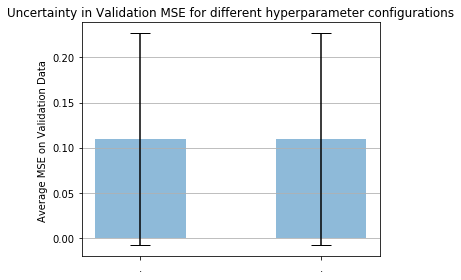

In [300]:
mean_of_average_mse_on_validation_list = np.mean(average_mse_on_validation_list)

std_of_average_mse_on_validation_list = np.std(average_mse_on_validation_list)

# Define individual_agents_name_list, positions, bar heights and list_of_standard_deviations_of_costs_of_all_agents bar heights
individual_agents_name_list = ['.',".",]
x_pos = np.arange(len(individual_agents_name_list))
list_of_mean_of_average_mse_on_validation_list = [mean_of_average_mse_on_validation_list,mean_of_average_mse_on_validation_list]
list_of_std_of_average_mse_on_validation_list = [std_of_average_mse_on_validation_list,std_of_average_mse_on_validation_list]

import matplotlib.pyplot as plt1

# Build the plot
fig, ax = plt1.subplots()
ax.bar(x_pos, list_of_mean_of_average_mse_on_validation_list,
       yerr=list_of_std_of_average_mse_on_validation_list,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10,
       width = 0.5, # defines the width of each bar, can pass a list of distince bar widths as well
        )
ax.set_ylabel('Average MSE on Validation Data ')
ax.set_xticks(x_pos)
ax.set_xticklabels(individual_agents_name_list)
ax.set_title('Uncertainty in Validation MSE for different hyperparameter configurations')
ax.yaxis.grid(True)

# Save the figure and show
plt1.tight_layout()
plt1.savefig('../plots/bar_plot_with_error_bars_for_average_validation_mse.png')
#plt1.show()

### Find the best hyperparameter configuration among all the trained estimators

In [301]:
estimator_index_for_least_avg_mse = average_mse_on_validation_list.index(min(average_mse_on_validation_list))
print("The best hyperparameter configuration index: {}".format(estimator_index_for_least_avg_mse))

The best hyperparameter configuration index: 10


## Train all 350 models on all the training samples (No cross-validation now.)


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 14, 400, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



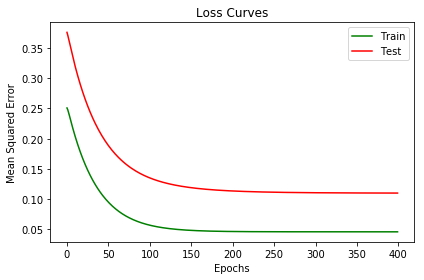


Traing with hyperparam config: 

[0.0005, 0.05, 0.75, 0.0, False, 14, 75, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



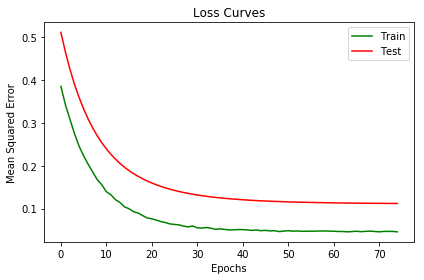


Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, False, 21, 375, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



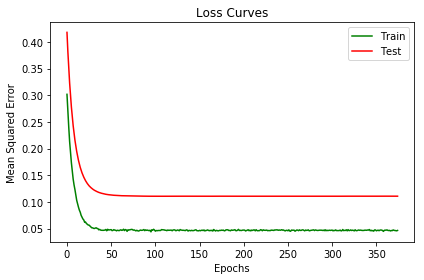


Traing with hyperparam config: 

[5e-05, 0.01, 0.5, 0.0, False, 24, 75, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



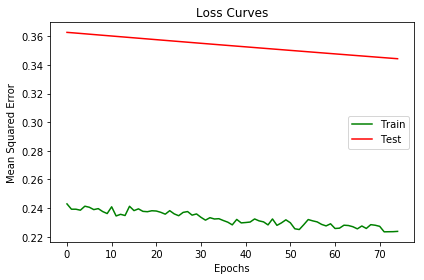


Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, True, 14, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



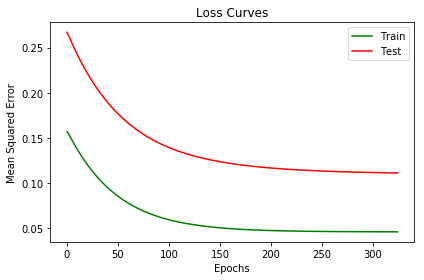


Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, False, 24, 175, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



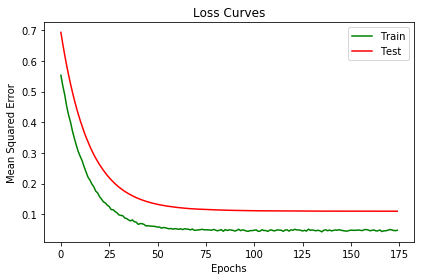


Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, False, 28, 75, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



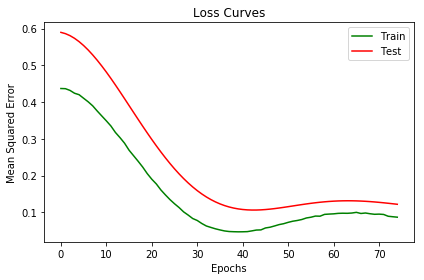


Traing with hyperparam config: 

[0.0003, 0.001, 0.5, 0.0, False, 14, 325, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



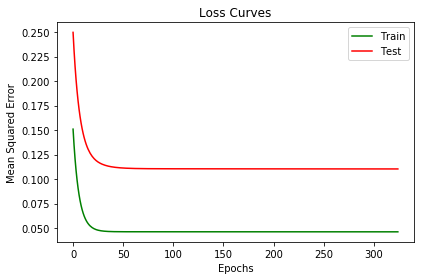


Traing with hyperparam config: 

[5e-05, 0.01, 0.5, 0.0, False, 24, 175, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



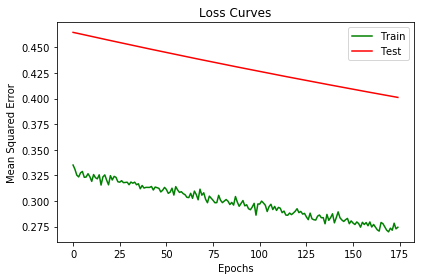


Traing with hyperparam config: 

[0.0003, 0.01, 0.5, 0.0, False, 17, 275, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



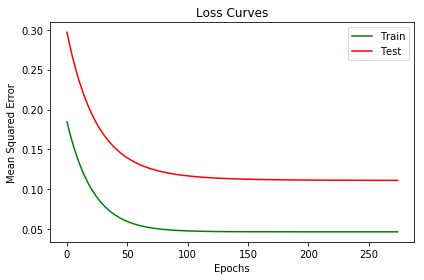


Traing with hyperparam config: 

[0.001, 5e-05, 0.99, 0.0, True, 21, 400, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 

*********************Best hyperparam configuration training.**************


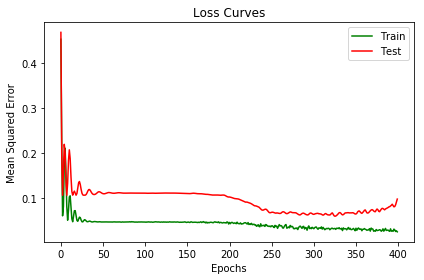

******************************************************************************

Traing with hyperparam config: 

[0.003, 0.1, 0.75, 0.0, False, 17, 375, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



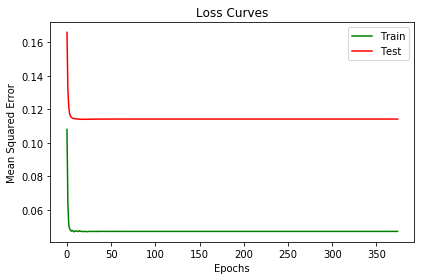


Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, True, 17, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



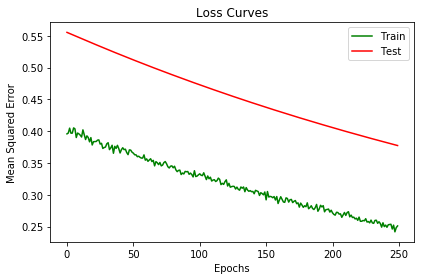


Traing with hyperparam config: 

[5e-05, 0.1, 0.99, 0.0, False, 24, 300, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



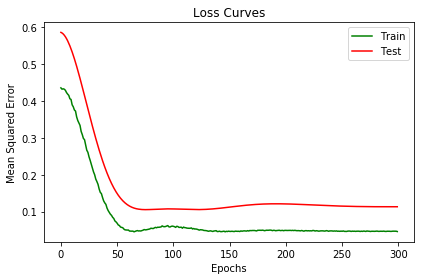


Traing with hyperparam config: 

[5e-05, 0.001, 0.5, 0.0, False, 28, 225, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



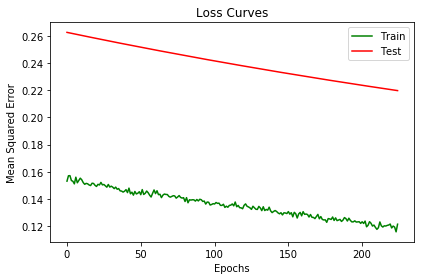


Traing with hyperparam config: 

[0.001, 0.05, 0.75, 0.0, True, 21, 50, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



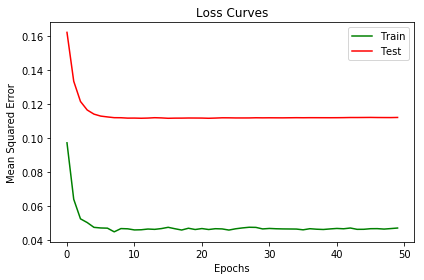


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 17, 250, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



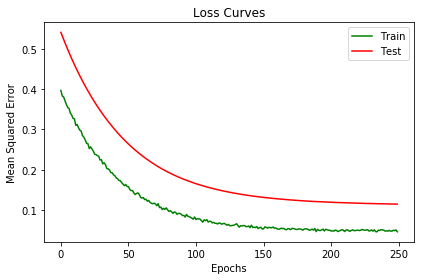


Traing with hyperparam config: 

[0.003, 1e-05, 0.5, 0.0, False, 28, 175, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



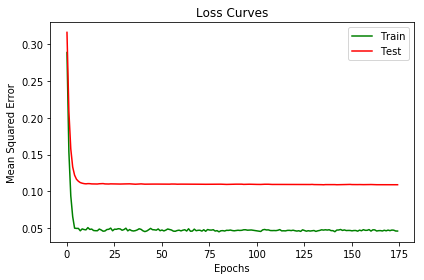


Traing with hyperparam config: 

[5e-05, 0.1, 0.5, 0.0, True, 35, 400, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



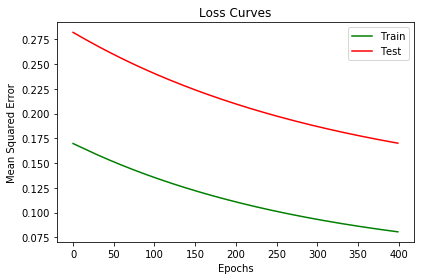


Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, True, 35, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



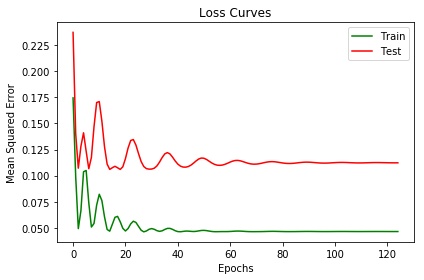

In [302]:
# Load the test data
testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
testing_data.head()

# Separate test features and targets
X_testing = testing_data.iloc[:,0:num_features].values
Y_testing = pd.DataFrame(testing_data["Hardness"]).values



last_epoch_training_losses = []

for idxx in range(len(random_hyperparameter_configurations)):
    
    print("\nTraing with hyperparam config: \n")
    print(random_hyperparameter_configurations[idxx], "\n")
    
    if idxx == estimator_index_for_least_avg_mse:
        print("*********************Best hyperparam configuration training.**************")
    
    net = NeuralNetRegressor(       module=Regression_Module,
                        
                                    optimizer__lr = random_hyperparameter_configurations[idxx][0],
                                    optimizer__weight_decay = random_hyperparameter_configurations[idxx][1],
                                    optimizer__momentum = random_hyperparameter_configurations[idxx][2],
                                    optimizer__dampening = random_hyperparameter_configurations[idxx][3],
                                    optimizer__nesterov = random_hyperparameter_configurations[idxx][4],
                                    module__num_units = random_hyperparameter_configurations[idxx][5],
                                    max_epochs = random_hyperparameter_configurations[idxx][6],
                                    module__dropout = random_hyperparameter_configurations[idxx][7],
                                    iterator_train__batch_size = random_hyperparameter_configurations[idxx][8],
                                    optimizer = random_hyperparameter_configurations[idxx][9],
                                    verbose = 0,
                                    warm_start = False,
                             
                                    # Added when cross-validation not done
                                    device = device_to_use,
                                    
                                    callbacks=[Epoch_TestData_Loss(X_testing, Y_testing, idxx)], #  <-- Notice the callback.

                                    )

    net.fit(X = X_training.values, y = Y_training.values, )
    
    net.save_params(f_params="../Saved_Models/nn_model_" + str(idxx) + ".pkl")
    # https://skorch.readthedocs.io/en/stable/user/save_load.html
    
    if idxx == estimator_index_for_least_avg_mse:
        print("******************************************************************************")
    

## Use all 350 models to predict on every test sample

In [303]:
test_predictions_by_all_estimators = []

# Using each hyperparameter-config trained model, predict on all the test samples
for model_num in range(0,no_of_hyperparam_configs):
    # Load the test data
    testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
    testing_data.head()

    # Separate test features and targets
    X_testing = testing_data.iloc[:,0:num_features].values #notice retaining only the underlying numpy arrays
    Y_testing = pd.DataFrame(testing_data["Hardness"]).values
    
    
    loaded_net = NeuralNetRegressor(module=Regression_Module,
                        
                                    #optimizer__lr = random_hyperparameter_configurations[model_num][0],
                                    #optimizer__weight_decay = random_hyperparameter_configurations[model_num][1],
                                    #optimizer__momentum = random_hyperparameter_configurations[model_num][2],
                                    #optimizer__dampening = random_hyperparameter_configurations[model_num][3],
                                    #optimizer__nesterov = random_hyperparameter_configurations[model_num][4],
                                    module__num_units = random_hyperparameter_configurations[model_num][5],
                                    #max_epochs = random_hyperparameter_configurations[model_num][6],
                                    #module__dropout = random_hyperparameter_configurations[model_num][7],
                                    #iterator_train__batch_size = random_hyperparameter_configurations[model_num][8],
                                    #optimizer = random_hyperparameter_configurations[model_num][9],
                                    verbose = 0,
                                    warm_start = False,
                             
                                    # Added when cross-validation not done
                                    device = device_to_use,
                                    
                                    #callbacks=[Epoch_TestData_Loss(X_testing, Y_testing)], #  <-- Notice the callback.

                                    )
    
    
        
    # Initialize the estimator with the trained parameters
    loaded_net.initialize() # <-- This is important!
    loaded_net.load_params(f_params="../Saved_Models/nn_model_" + str(model_num) + ".pkl")
    
    # Since we are using a torch model that has dropout layers, important to switch to eval() mode before predicting
    loaded_net.module_.eval()
    
    # Predict using this estimator
    test_predictions = loaded_net.predict(X_testing.astype(np.float32))
    # Store the predictions
    test_predictions_by_all_estimators.append(test_predictions)
    

In [304]:
# Save the predictions made by all the estimators

with open('test_predictions_by_all_estimators.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(test_predictions_by_all_estimators)

# np_array_predictions = np.array(test_predictions_by_all_estimators)
# np.savetxt("test_predictions_by_all_estimators.csv", np_array_predictions, delimiter = ",")

## Plot Uncertainty among different models trained for each test sample


Test Sample No. : 0
Predictions for this sample by all models: [0.47472897 0.47014201 0.47948748 0.05945479 0.46857762 0.47623813
 0.67381954 0.47615394 0.00660279 0.47730935 0.3339693  0.45650071
 0.02292003 0.46109024 0.21139699 0.46771133 0.45277637 0.48071674
 0.29442373 0.46786693]
mean_prediction_for_this_test_sample: 0.38559434860944747
std_of_all_predictions_for_this_test_sample: 0.17311201634406942


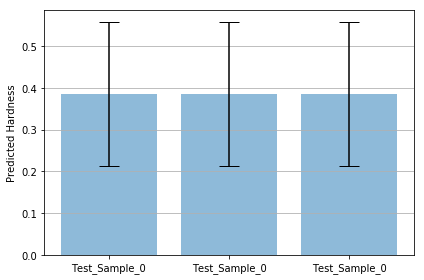


Test Sample No. : 1
Predictions for this sample by all models: [0.47725296 0.46989834 0.47870505 0.05922719 0.46868792 0.47890514
 0.672445   0.47790357 0.00482688 0.47699279 0.36275721 0.45650071
 0.02635327 0.46081305 0.21064174 0.46764302 0.45282507 0.48258293
 0.29412752 0.46786693]
mean_prediction_for_this_test_sample: 0.38734781425446274
std_of_all_predictions_for_this_test_sample: 0.17277857721268147


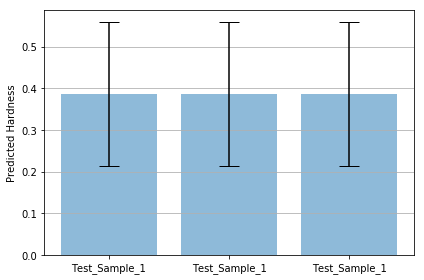


Test Sample No. : 2
Predictions for this sample by all models: [0.47856039 0.46973732 0.47878933 0.05929394 0.46820408 0.47939873
 0.6734283  0.47825012 0.0027807  0.47662142 0.50092894 0.45650071
 0.02577284 0.46114504 0.20990188 0.46780646 0.45382419 0.48581874
 0.29275653 0.46786693]
mean_prediction_for_this_test_sample: 0.3943693293258548
std_of_all_predictions_for_this_test_sample: 0.17499329348618287


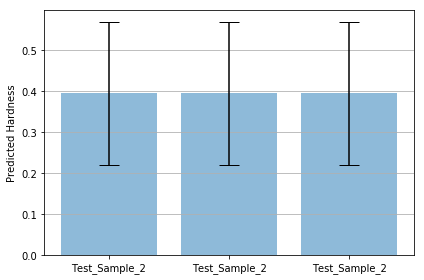


Test Sample No. : 3
Predictions for this sample by all models: [0.47737521 0.47041413 0.48046899 0.05913971 0.46879166 0.4749527
 0.67282784 0.47647369 0.00620425 0.47872707 0.24742559 0.45650071
 0.0234419  0.46065211 0.21309394 0.46763992 0.45004511 0.4764106
 0.29403809 0.46786693]
mean_prediction_for_this_test_sample: 0.38112450689077376
std_of_all_predictions_for_this_test_sample: 0.17521684046467492


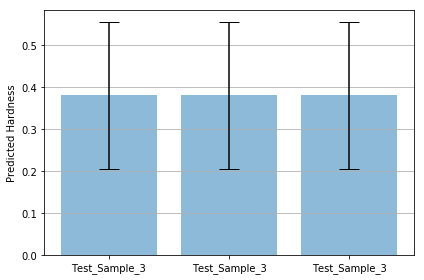


Test Sample No. : 4
Predictions for this sample by all models: [0.47763699 0.46968839 0.47896105 0.05890946 0.46535704 0.47942442
 0.67228222 0.47763813 0.00385897 0.47663507 0.41381916 0.45650071
 0.02881848 0.46113706 0.20986292 0.46782559 0.45386916 0.4850319
 0.29390904 0.46786693]
mean_prediction_for_this_test_sample: 0.38995163403451444
std_of_all_predictions_for_this_test_sample: 0.17271806541811716


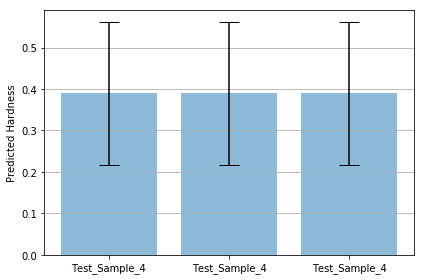


Test Sample No. : 5
Predictions for this sample by all models: [0.47792763 0.46928924 0.47873366 0.05872131 0.47009325 0.47861144
 0.67305684 0.47822315 0.00396352 0.47674617 0.45771644 0.45650071
 0.02522437 0.4610863  0.20985886 0.46775973 0.45196486 0.48463845
 0.29258382 0.46786693]
mean_prediction_for_this_test_sample: 0.39202833399176595
std_of_all_predictions_for_this_test_sample: 0.17381664325547366


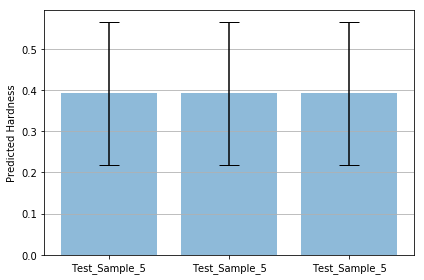


Test Sample No. : 6
Predictions for this sample by all models: [0.47736812 0.46902549 0.47894704 0.05876744 0.46898064 0.4790535
 0.67230302 0.47765702 0.00254997 0.47650787 0.38424987 0.45650071
 0.02778506 0.46123078 0.20953621 0.46781847 0.45241681 0.48586375
 0.29291973 0.46786693]
mean_prediction_for_this_test_sample: 0.3883674208074808
std_of_all_predictions_for_this_test_sample: 0.172992079621624


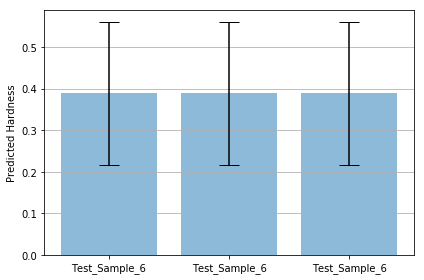


Test Sample No. : 7
Predictions for this sample by all models: [0.47516531 0.46949491 0.47873199 0.05893744 0.46022618 0.47909302
 0.67362022 0.47603768 0.00301284 0.47710699 0.22393578 0.45650071
 0.02561203 0.46094519 0.20999703 0.46740809 0.45078045 0.48015606
 0.2887584  0.46786693]
mean_prediction_for_this_test_sample: 0.3791693622246385
std_of_all_predictions_for_this_test_sample: 0.17650796688535716


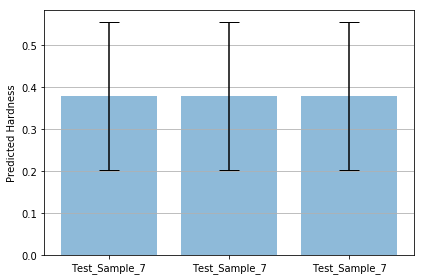


Test Sample No. : 8
Predictions for this sample by all models: [0.47693461 0.46949384 0.47874549 0.05929122 0.47054657 0.47838318
 0.67245525 0.47781539 0.00432288 0.47692686 0.36066884 0.45650071
 0.02551048 0.46091452 0.21021906 0.4676477  0.45227733 0.48316252
 0.29347199 0.46786693]
mean_prediction_for_this_test_sample: 0.3871577687561512
std_of_all_predictions_for_this_test_sample: 0.17298952202932943


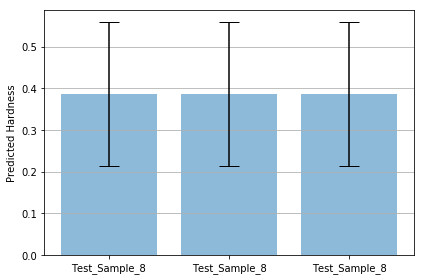


Test Sample No. : 9
Predictions for this sample by all models: [0.47829026 0.46919814 0.47888845 0.05877933 0.46736124 0.47851864
 0.67266017 0.47789896 0.00371059 0.4768388  0.41127586 0.45650071
 0.02751986 0.46121931 0.20952156 0.46786922 0.45239925 0.48599264
 0.29272255 0.46786693]
mean_prediction_for_this_test_sample: 0.389751623570919
std_of_all_predictions_for_this_test_sample: 0.17298669181339615


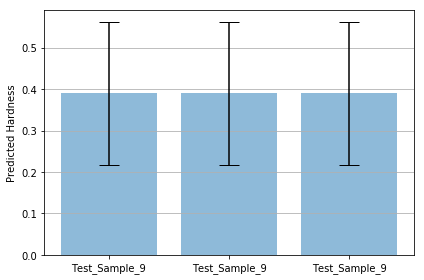


Test Sample No. : 10
Predictions for this sample by all models: [0.47838128 0.46969661 0.47868884 0.05931479 0.46801427 0.47853565
 0.67311841 0.47838974 0.00436071 0.47667861 0.47995442 0.45650071
 0.02541535 0.46104673 0.2101948  0.46777439 0.452867   0.48441747
 0.29332522 0.46786693]
mean_prediction_for_this_test_sample: 0.393227095156908
std_of_all_predictions_for_this_test_sample: 0.17413156806531557


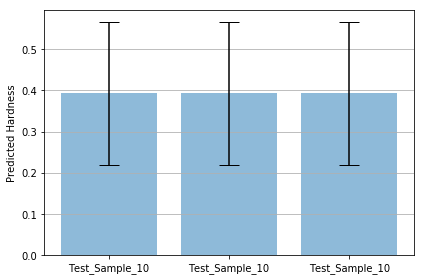


Test Sample No. : 11
Predictions for this sample by all models: [0.47330832 0.46941802 0.47954574 0.05940334 0.46573651 0.47757214
 0.67432135 0.47625452 0.00440012 0.47683376 0.22406676 0.45650071
 0.02089622 0.46077055 0.21011907 0.46741253 0.44985723 0.48358548
 0.28713587 0.46786693]
mean_prediction_for_this_test_sample: 0.37925025895237924
std_of_all_predictions_for_this_test_sample: 0.17701655560369542


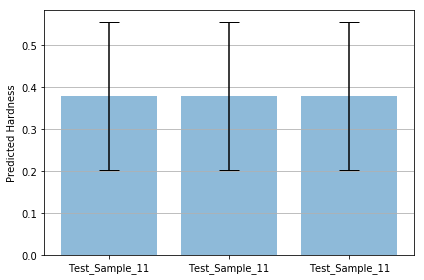

In [306]:
no_of_test_samples = len(testing_data)



for test_sample_num in range(no_of_test_samples):
    print("\nTest Sample No. : {}".format(test_sample_num))
    
    np_array_test_predictions_by_all_estimators = np.array(test_predictions_by_all_estimators).squeeze()
    # squeeze() to remove the Channel dimension of torch

    predictions_for_this_test_sample = np_array_test_predictions_by_all_estimators[:,test_sample_num]
    
    print("Predictions for this sample by all models: {}".format(predictions_for_this_test_sample))
    
    mean_prediction_for_this_test_sample = np.mean(predictions_for_this_test_sample)
    print("mean_prediction_for_this_test_sample: {}".format(mean_prediction_for_this_test_sample))

    std_of_all_predictions_for_this_test_sample = np.std(predictions_for_this_test_sample)
    print("std_of_all_predictions_for_this_test_sample: {}".format(std_of_all_predictions_for_this_test_sample))

    # Define individual_agents_name_list, positions, bar heights and list_of_standard_deviations_of_costs_of_all_agents bar heights
    test_samples_name_list = ["Test_Sample_" + str(test_sample_num),"Test_Sample_" + str(test_sample_num), "Test_Sample_" + str(test_sample_num),]
    x_pos = np.arange(len(test_samples_name_list))
    list_of_means = [mean_prediction_for_this_test_sample, mean_prediction_for_this_test_sample, mean_prediction_for_this_test_sample,]
    list_of_standard_deviations = [std_of_all_predictions_for_this_test_sample, std_of_all_predictions_for_this_test_sample, std_of_all_predictions_for_this_test_sample,]
    
    import matplotlib.pyplot as plt2
    
    # Build the plot
    fig, ax = plt2.subplots()
    ax.bar(x_pos, list_of_means,
           yerr=list_of_standard_deviations,
           align='center',
           alpha=0.5,
           ecolor='black',
           capsize=10
          )
    ax.set_ylabel('Predicted Hardness')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(test_samples_name_list)
    ax.set_title('')
    ax.yaxis.grid(True)

    # Save the figure and show
    plt2.tight_layout()
    plt2.savefig('../plots/bar_plot_with_error_bars_for_test_sample_' + str(test_sample_num) + '.png')
    plt2.show()
    

## Target Predictions for all test samples by the "best hyperparam" model

In [307]:
best_hyperparam_predictions = test_predictions_by_all_estimators[estimator_index_for_least_avg_mse]

#The maximum and minimum targets of the training data were [983.91] and [116.] from feature engineering file

max_hardness = 983.91
min_hardness = 116.

def convert_to_original_scale(scaled_hardness):
    original_scale_hardness = (scaled_hardness * (max_hardness - min_hardness)) + min_hardness
    return original_scale_hardness

for test_sample in range(len(best_hyperparam_predictions)):
    print("True Hardness: {}".format(convert_to_original_scale(Y_testing[test_sample])))
    print("Predicted Hardness: {}".format(convert_to_original_scale(best_hyperparam_predictions[test_sample])))
    print("")

True Hardness: [373.65640529]
Predicted Hardness: [405.85529085]

True Hardness: [517.04779606]
Predicted Hardness: [430.84060663]

True Hardness: [891.0696757]
Predicted Hardness: [550.76123492]

True Hardness: [373.65640529]
Predicted Hardness: [330.74314033]

True Hardness: [540.71297677]
Predicted Hardness: [475.15779066]

True Hardness: [983.91]
Predicted Hardness: [513.25667127]

True Hardness: [972.56751694]
Predicted Hardness: [449.49430121]

True Hardness: [194.41716683]
Predicted Hardness: [310.35610534]

True Hardness: [602.74655695]
Predicted Hardness: [429.02809121]

True Hardness: [871.18532268]
Predicted Hardness: [472.95043482]

True Hardness: [654.13780736]
Predicted Hardness: [532.55724198]

True Hardness: [116.]
Predicted Hardness: [310.46978524]



### MSE for the test samples by the "best hyperparam" model

In [308]:
# get Root Mean Squared Error
MSE(Y_testing,best_hyperparam_predictions)**(1/2)

0.3120772157181459

## R2 plot for the best model

True test targets: 
[[0.29686996]
 [0.46208454]
 [0.89303001]
 [0.29686996]
 [0.4893514 ]
 [1.        ]
 [0.98693127]
 [0.09035173]
 [0.56082607]
 [0.87011939]
 [0.62003872]
 [0.        ]]

Best hyperparam-trained model predictions of test targets: 
[[0.3339693 ]
 [0.36275721]
 [0.50092894]
 [0.24742559]
 [0.41381916]
 [0.45771644]
 [0.38424987]
 [0.22393578]
 [0.36066884]
 [0.41127586]
 [0.47995442]
 [0.22406676]]
Best-hyperparam R2 score: 0.0810738916385062


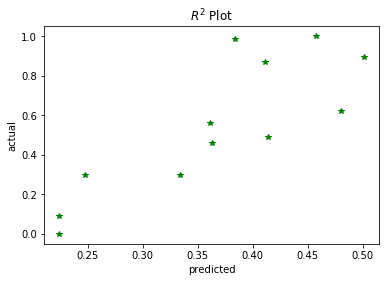

In [309]:
# R^2 plot
print("True test targets: \n{}".format(Y_testing))
print("\nBest hyperparam-trained model predictions of test targets: \n{}".format(best_hyperparam_predictions))

print("Best-hyperparam R2 score: {}".format(r2_score(Y_testing,best_hyperparam_predictions)))

plt.plot(best_hyperparam_predictions,Y_testing,'g*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ Plot');

# IGNORE ANYTHING BELOW THIS

In [ ]:
common_param_grid = {
    
    "lr" : lr,
    "max_epochs" : max_epochs,
    
    
    
    #list all the formal arguments of the torch module that u pass to skorch regressor here beginning with module__
    "module__num_units" : no_of_nodes_per_layer,
    "module__dropout" : dropout_probability_per_node,
    #not passing the activation here though
    
    
    
    "optimizer" : optimizers,
    "optimizer__weight_decay": weight_decay_for_regularization,
    "optimizer__momentum" : momentum_vals,
    "optimizer__dampening" : momentum_dampening,
    "optimizer__nesterov" : nesterov, 
    
    
    
    "iterator_train__batch_size": minibatch_size,
    #"callbacks__scheduler__epoch": [10, 50, 100], #learning rate scheduler    
}

#### Create a Randomized Search Instance and pass the estimator, thehyperparameters' grid, the no of random samples to take from the grid, and the value of k for k-Fold cross-validation.

In [ ]:
sgd_randomized_search = RandomizedSearchCV(estimator = skorch_regressor,
                                          scoring = "neg_mean_squared_error", #negative since the scorer tries to maximize this
                                          param_distributions = common_param_grid,
                                          n_iter = 1, #350,  #no of random samples to take from the grid                                                    
                                          cv = 2, #20,
                                          return_train_score = True # produce metrics on the train set as well
                                          )

#skorch_regressor.get_params().keys()

### Train the models.

In [ ]:
assert len(X_training) == len(Y_training)
randomized_search_result = sgd_randomized_search.fit(X_training.values, Y_training.values)

#dataframe.values gives the underlying numpy array of the data frame, doing this conversion since pandas data frame 
#is not supported.

### Save and view the best parameters and hyperparameters obtained from randomized search.

In [ ]:
# Import the parameter combinations and the corresponding results into a pandas dataframe
pd.DataFrame(randomized_search_result.cv_results_)

#Each row of this dataframe gives one combination of the hyperparameters used and the corresponding performance of the
#estimator used.

### Interpretation of cv_results_
Column "mean_test_score" is the average of columns split_0_test_score, split_1_test_score, split_2_test_score...split_k_test_score for "this" hyperparameter configuration.<br><br>
"randomized_search_result.best_score_" will return the max value of the column mean_test_score.<br><br>
Column "rank_test_score" ranks all hyperparameter combinations by the values of mean_test_score.<br><br>
Column "std_test_score" is the standard deviation of split_0_test_score, split_1_test_score,...., split_k_test_score. It shows how consistently "this" set of hyperparameters is performing on the hold-out data of each k-fold validation.

### Save the results

In [ ]:
#saving the best estimator i.e., the best neural network parameters
# randomized_search_result.best_estimator_ gives the neural net with best parameters
joblib.dump(randomized_search_result.best_estimator_, 'best_params_of_NN_by_randomized_search.pkl', compress = 1)

#saving the hyperparameters that were used to get this best estimator
# randomized_search_result.best_params_ gives the best hyperparameters that were used to get this best estimator
joblib.dump(randomized_search_result.best_params_, 'best_hyperparams_for_NN_by_randomized_search.pkl', compress = 1)

#saving all 350 models' hyperparameter configurations and the neural network parameters



# Displaying the best hyperparameters configuration
randomized_search_result.best_params_

In [ ]:
def report(results, num_of_top_results_to_report = 5):
    #this utility method was found online.
    
    for idx1 in range(0, num_of_top_results_to_report):
        candidates = np.flatnonzero(results['rank_test_score'] == idx1)
        for candidate in candidates:
            print("Model with rank: {0}".format(idx1))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(sgd_randomized_search.cv_results_,num_of_top_results_to_report = 3)

### Visualize training and validation loss

In [ ]:
# get training and validation loss
epochs = [i for i in range(len(sgd_randomized_search.best_estimator_.history))]
training_loss = sgd_randomized_search.best_estimator_.history[:,'train_loss']
validation_loss = sgd_randomized_search.best_estimator_.history[:,'valid_loss']

In [ ]:
plt.plot(epochs,training_loss,'g-');
plt.plot(epochs,validation_loss,'r-');
plt.title('Training and Validation Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

## Test on Test Data

In [ ]:
# Predict on test data
testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
testing_data.head()

In [ ]:
# Separate features and targets
X_testing = testing_data.iloc[:,0:num_features].values #notice retaining only the underlying numpy arrays
Y_testing = pd.DataFrame(testing_data["Hardness"]).values

Y_predictions_on_test_data = sgd_randomized_search.best_estimator_.predict(X_testing.astype(np.float32))

In [ ]:
Y_predictions_on_test_data = sgd_randomized_search.best_estimator_.predict(X_testing.astype(np.float32))

In [ ]:
Y_testing

In [ ]:
Y_predictions_on_test_data

In [ ]:
# get Root Mean Squared Error
MSE(Y_testing,Y_predictions_on_test_data)**(1/2)

In [ ]:
# Kernel Density Estimation Plot

# sns.kdeplot(Y_predictions_on_test_data.squeeze(), label='predictions of the model', shade=True)
# sns.kdeplot(Y_testing.squeeze(), label='true values', shade=True)
# plt.xlabel('Hardness');

In [ ]:
# Dist Plot

# sns.distplot(Y_testing.squeeze()-Y_predictions_on_test_data.squeeze(),label='error', bins = 10);
# plt.xlabel('Error');

In [ ]:
# R^2 plot

print(r2_score(Y_testing,Y_predictions_on_test_data))

plt.plot(Y_predictions_on_test_data,Y_testing,'g*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ Plot');

#### View the actual values vs predicted values in real scale

In [ ]:
#The maximum and minimum targets of the training data were [983.91] and [116.] from feature engineering file

max_hardness = 983.91
min_hardness = 116.

def convert_to_original_scale(scaled_hardness):
    original_scale_hardness = (scaled_hardness * (max_hardness - min_hardness)) + min_hardness
    return original_scale_hardness

for test_sample in range(len(Y_predictions_on_test_data)):
    print("True Hardness: {}".format(convert_to_original_scale(Y_testing[test_sample])))
    print("Predicted Hardness: {}".format(convert_to_original_scale(Y_predictions_on_test_data[test_sample])))
    print("")